In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Set seeds for reproducibility
import tensorflow as tf
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-05-02 07:03:51.846535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746169432.049529      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746169432.107367      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define base directory and classes
base_dir = r'/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
classes = ['Normal', 'Cyst', 'Tumor', 'Stone']
label_mapping = {'Normal': 0, 'Cyst': 1, 'Tumor': 2, 'Stone': 3}

In [5]:
def make_balanced_df(classes, base_dir, samples_per_class=1300):
    data = []
    for label in classes:
        folder_path = os.path.join(base_dir, label)
        all_files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('jpg', 'png'))])
        sampled_files = np.random.choice(all_files, samples_per_class, replace=False)
        data.extend([(fp, label) for fp in sampled_files])
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    df['label'] = df['label'].map(label_mapping).astype(str)
    return df

# Load balanced data
df = make_balanced_df(classes, base_dir)

In [6]:
# Split dataset deterministically
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=SEED)

In [7]:
# Define base learners
base_learners = [
    ('svm', SVC(kernel='rbf', probability=True)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

# Define meta learner
meta_learner = LogisticRegression(max_iter=1000)

In [9]:
from tensorflow.keras.models import load_model

# Load your previously trained model
model = load_model("/kaggle/input/inceptionresnetv2-balanced/tensorflow2/default/1/InceptionResNetv2 Balanced.keras") 

I0000 00:00:1746169732.162629      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
from tensorflow.keras.models import Model

# Extract features from the second-to-last layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)


In [11]:
from tqdm import tqdm

def extract_features(df):
    features = []
    labels = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        img = load_img(row['file_path'], target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        feature = feature_extractor.predict(img_array, verbose=0)
        features.append(feature.flatten())
        labels.append(row['label'])
    return np.array(features), np.array(labels)

In [12]:
# Extract features
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X_train, y_train = extract_features(train_df)
X_valid, y_valid = extract_features(valid_df)
X_test, y_test = extract_features(test_df)

  0%|          | 0/3328 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746169772.178382     102 service.cc:148] XLA service 0x7c8d30003820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746169772.179080     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746169774.380543     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746169778.624101     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 1040/1040 [01:42<00:00, 10.14it/s]


In [13]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stacking_model.fit(X_train_scaled, y_train)


StackingClassifier(cv=5,
                   estimators=[('svm', SVC(probability=True)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=No...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=LogisticRegression(max_iter=1000))

In [24]:
# Predict
y_pred = stacking_model.predict(X_test_scaled)


In [25]:
# Evaluation
print("Classification Report (Stacking Ensemble):")
print(classification_report(y_test, y_pred,digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report (Stacking Ensemble):
              precision    recall  f1-score   support

           0      0.992     0.988     0.990       260
           1      0.992     1.000     0.996       260
           2      0.992     0.992     0.992       260
           3      0.996     0.992     0.994       260

    accuracy                          0.993      1040
   macro avg      0.993     0.993     0.993      1040
weighted avg      0.993     0.993     0.993      1040

Accuracy: 0.9932692307692308


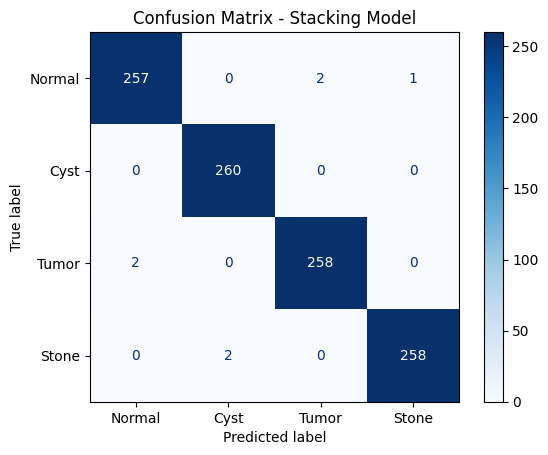

In [35]:
# Convert string labels to integers
y_test_numeric = [int(label) for label in y_test]
y_pred_numeric = [int(label) for label in y_pred]

# Confusion Matrix
cm = confusion_matrix(y_test_numeric, y_pred_numeric, labels=[0, 1, 2, 3])

# Display confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Stacking Model")
plt.show()


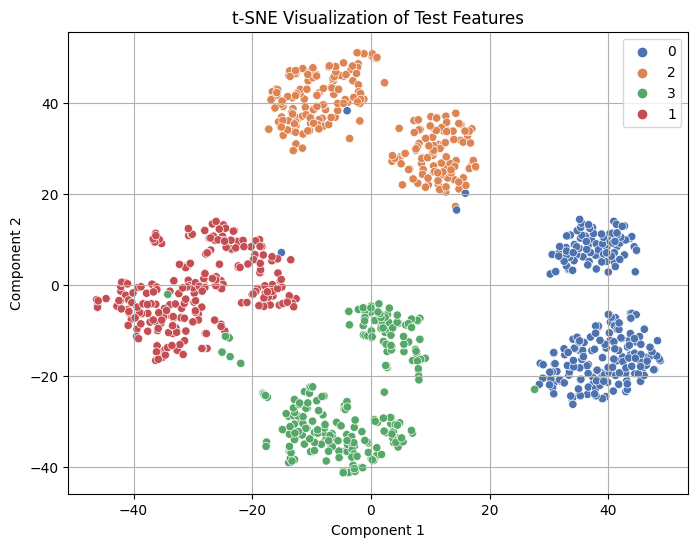

In [36]:

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_test, palette='deep', legend='full')
plt.title('t-SNE Visualization of Test Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

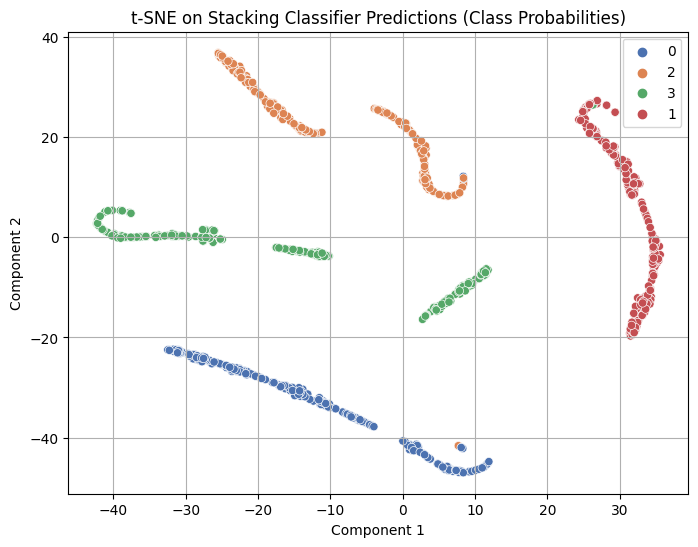

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted class probabilities from the stacking ensemble
proba = stacking_model.predict_proba(X_test_scaled)

# Apply t-SNE to the probability distribution output
tsne_output = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(proba)

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=y_test, palette='deep', legend='full')
plt.title("t-SNE on Stacking Classifier Predictions (Class Probabilities)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

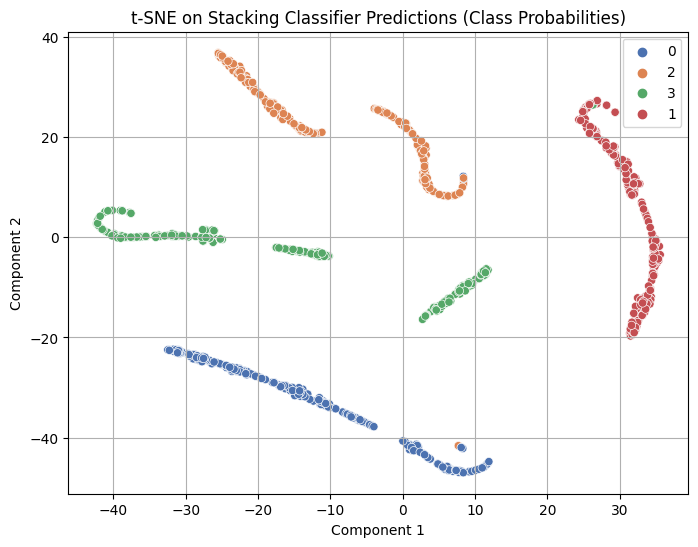

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted class probabilities from the stacking ensemble
proba = stacking_model.predict_proba(X_test_scaled)

# Apply t-SNE to the probability distribution output
tsne_output = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(proba)

# Plot the t-SNE result
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=y_test, palette='deep', legend='full')
plt.title("t-SNE on Stacking Classifier Predictions (Class Probabilities)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()



==== SVM (RBF) ====
Classification Report:
              precision    recall  f1-score   support

           0      0.988     0.988     0.988       260
           1      0.992     1.000     0.996       260
           2      0.992     0.992     0.992       260
           3      0.996     0.988     0.992       260

    accuracy                          0.992      1040
   macro avg      0.992     0.992     0.992      1040
weighted avg      0.992     0.992     0.992      1040

Accuracy: 0.9923076923076923


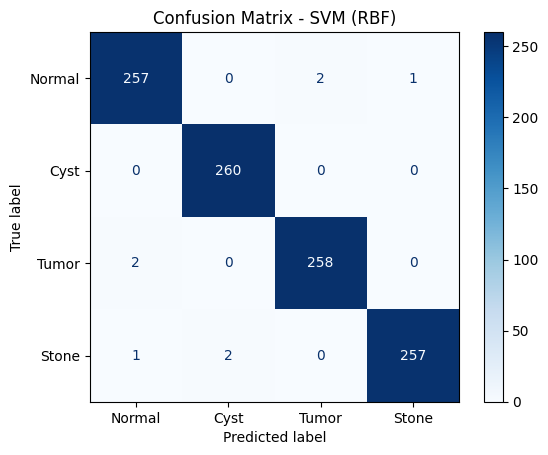


==== Random Forest ====
Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.985     0.988       260
           1      0.992     1.000     0.996       260
           2      0.989     0.992     0.990       260
           3      0.996     0.992     0.994       260

    accuracy                          0.992      1040
   macro avg      0.992     0.992     0.992      1040
weighted avg      0.992     0.992     0.992      1040

Accuracy: 0.9923076923076923


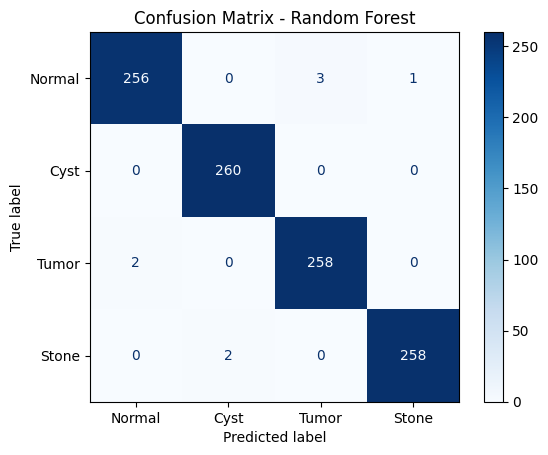


==== K-Nearest Neighbors ====
Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.988     0.990       260
           1      0.992     1.000     0.996       260
           2      0.992     0.992     0.992       260
           3      0.996     0.992     0.994       260

    accuracy                          0.993      1040
   macro avg      0.993     0.993     0.993      1040
weighted avg      0.993     0.993     0.993      1040

Accuracy: 0.9932692307692308


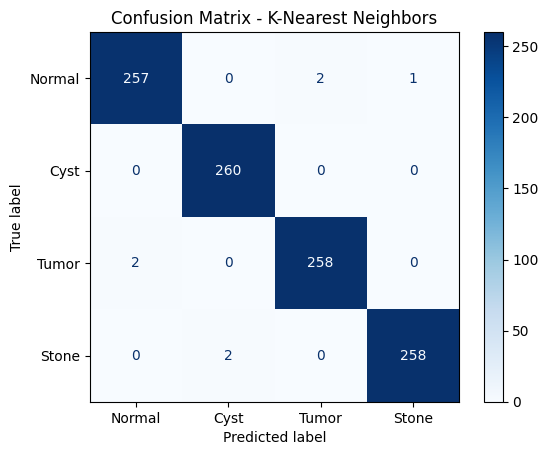


==== XGBoost ====
Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.988     0.990       260
           1      0.992     0.992     0.992       260
           2      0.989     0.992     0.990       260
           3      0.988     0.988     0.988       260

    accuracy                          0.990      1040
   macro avg      0.990     0.990     0.990      1040
weighted avg      0.990     0.990     0.990      1040

Accuracy: 0.9903846153846154


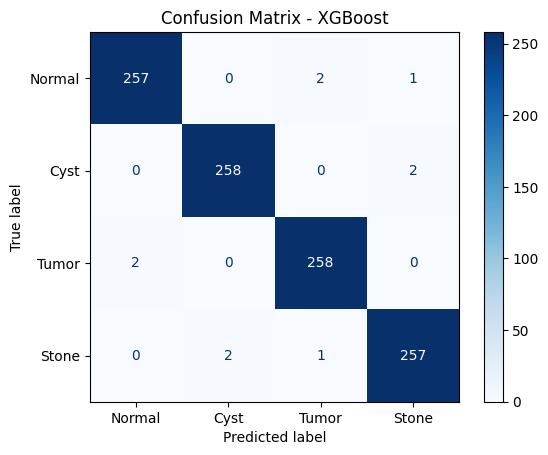

In [43]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Label Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Step 2: Define Models
models = {
    "SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Step 3: Define Class Names (Optional, if you need to customize the output labels)
class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Step 4: Train and Evaluate Each Model
for name, model in models.items():
    print(f"\n==== {name} ====")
    
    # Train the model
    model.fit(X_train_scaled, y_train_enc)
    
    # Predict
    y_pred_enc = model.predict(X_test_scaled)
    y_pred_labels = le.inverse_transform(y_pred_enc)
    # Predict
    y_pred_enc = model.predict(X_test_scaled)
    
    # Classification report with class names and decimals
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_, digits=3))
    print("Accuracy:", accuracy_score(y_test_enc, y_pred_enc))
    
    # Confusion matrix using encoded labels, display class names
    cm = confusion_matrix(y_test_enc, y_pred_enc, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
